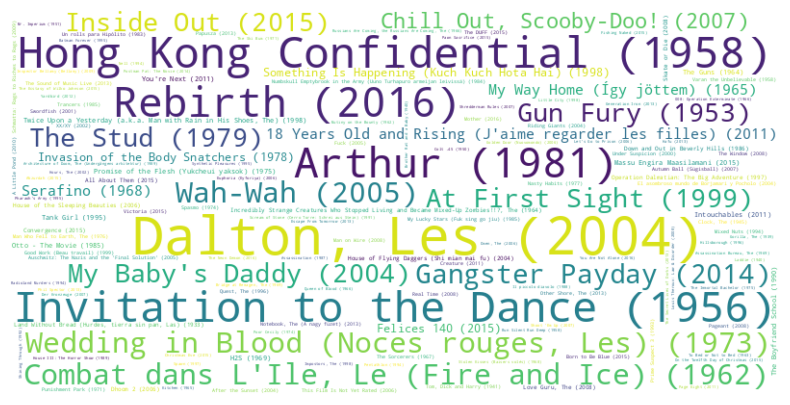

In [7]:
import redis
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt

r = redis.Redis(host='localhost', port=6379, db=0)

average_ratings = defaultdict(lambda: {'total': 0, 'count': 0})
for key in r.scan_iter("ratings:*"):
    for _, rating in r.zrange(key, 0, -1, withscores=True):
        movie_id = key.decode().split(":")[1]
        average_ratings[movie_id]['total'] += rating
        average_ratings[movie_id]['count'] += 1

wordcloud_data = {}
for movie_id, data in average_ratings.items():
    if data['count'] > 0:
        avg_rating = data['total'] / data['count']
        title_data = r.hget(f"movie:{movie_id}", "title")
        
        if title_data:
            title = title_data.decode('utf-8')
            wordcloud_data[title] = avg_rating

# Generate and display word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(wordcloud_data)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


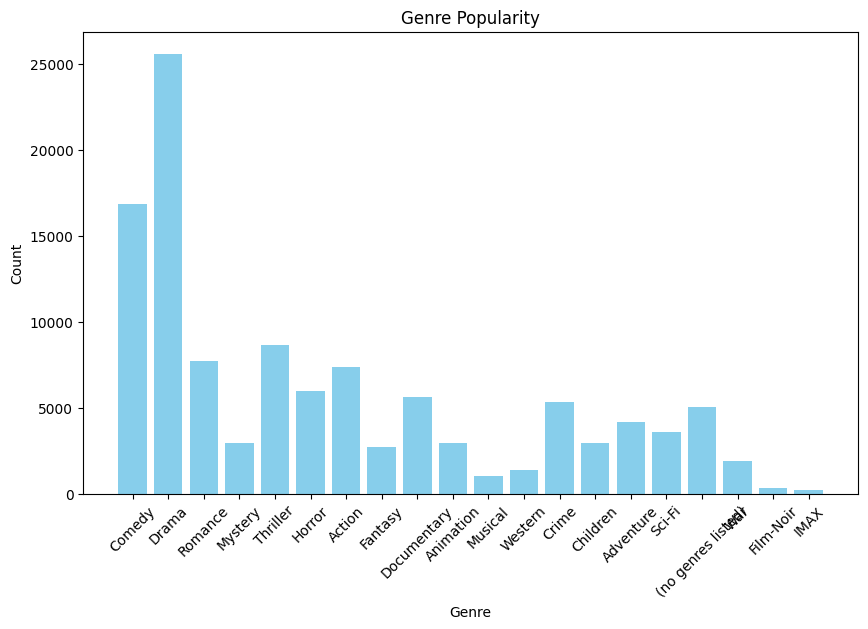

In [10]:
from collections import Counter
import json

genre_counts = Counter()
for key in r.scan_iter("movie:*"):
    genre_data = r.hget(key, 'genres')
    if genre_data:
        genres = json.loads(genre_data)
        genre_counts.update(genres)

# Prepare data for plotting
genres = list(genre_counts.keys())
counts = list(genre_counts.values())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(genres, counts, color='skyblue')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.title('Genre Popularity')
plt.show()

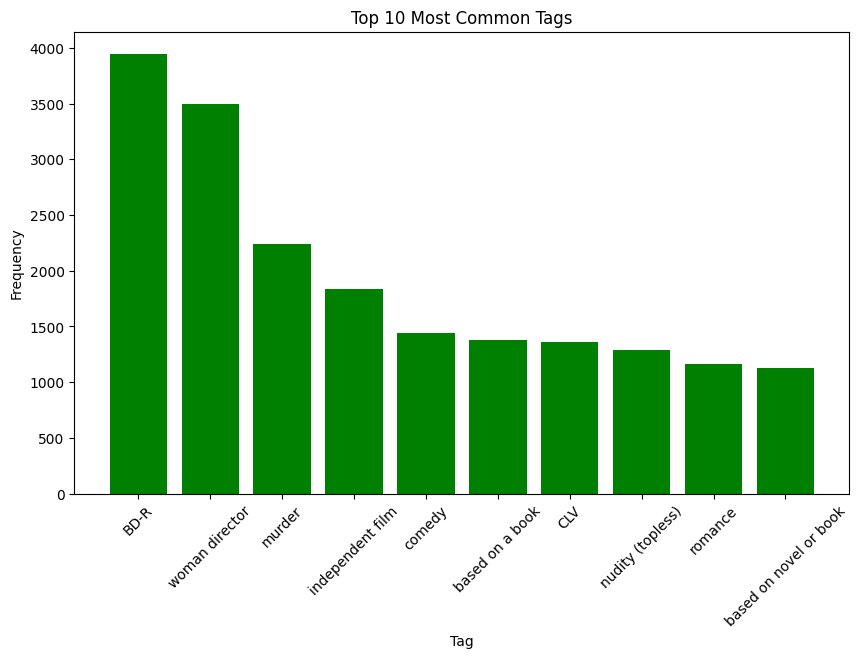

In [11]:
tag_counts = Counter()
for key in r.scan_iter("tags:*"):
    tags = r.smembers(key)
    for tag in tags:
        tag_counts[tag.decode('utf-8')] += 1

# Prepare data for plotting
top_tags = [tag for tag, _ in tag_counts.most_common(10)]
counts = [count for _, count in tag_counts.most_common(10)]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(top_tags, counts, color='green')
plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.title('Top 10 Most Common Tags')
plt.show()

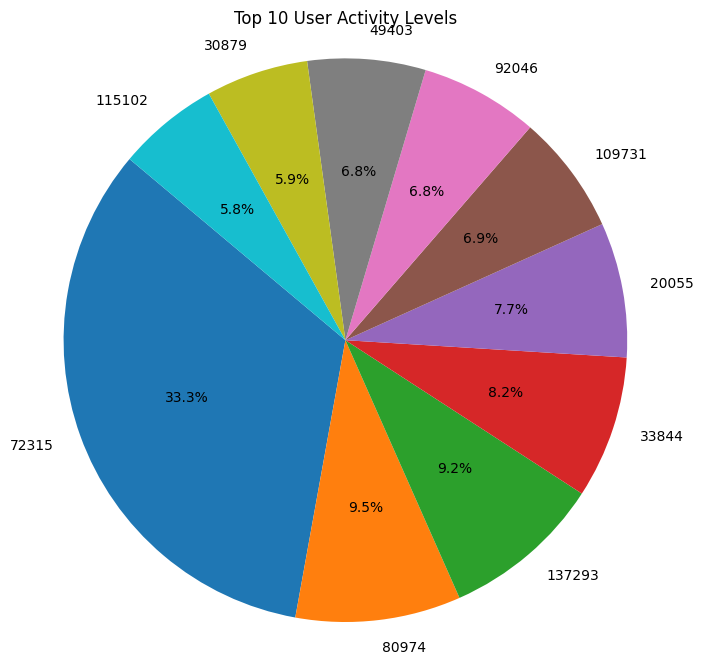

In [12]:
user_activity = {}
for key in r.scan_iter("ratings:*"):
    user_id = key.decode().split(":")[1]
    user_activity[user_id] = r.zcard(key)

sorted_activity = sorted(user_activity.items(), key=lambda x: x[1], reverse=True)

# Selecting top 10 users for a clearer chart
top_users = [user_id for user_id, _ in sorted_activity[:10]]
activity_counts = [count for _, count in sorted_activity[:10]]

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(activity_counts, labels=top_users, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title('Top 10 User Activity Levels')
plt.show()